In [4]:
from google.colab import drive
drive.mount('/content/drive')

!tar xf drive/MyDrive/Colab\ Notebooks/data/mnist-png-format.tar.xz -C /content/
#!tar xf drive/MyDrive/Colab\ Notebooks/data/mnist-png-format-permutated.tar.xz -C /content/

Mounted at /content/drive


Enable CUDA for GPU acceleration 


In [1]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


Validation and accuracy Plot function

In [2]:
import matplotlib.pyplot as plt
def plot(t_acc, t_loss, v_acc, v_loss):
  epochs = [*range(1,len(t_acc)+1, 1)]

  fig, axes = plt.subplots(1,2, figsize=(10,3))
  axes[0].plot(epochs, t_acc, label='Training Accuracy')
  axes[0].plot(epochs, v_acc, label='Validation Accuracy')
  axes[0].set_title('Accuracy')
  axes[0].legend()
 
  axes[1].plot(epochs, t_loss, label='Training loss')
  axes[1].plot(epochs, v_loss, label='Validation loss')
  axes[1].set_title('Loss')
  axes[1].legend()

  fig.tight_layout()
  plt.show()


Import data in PNG form and split into Train, Test, Validate and load


In [34]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose, Grayscale

train_set = '/content/mnist-png-format/train'
test_set = '/content/mnist-png-format/test'

batch_size = 128
workers = 0

transforms = Compose([
                        Grayscale(num_output_channels=1),   # PNG file is RGB 3 layer convert to greyscal 1 layer
                        ToTensor(),           
                        Normalize(mean=(0.5), std=(0.5)), 
                        ])

train_dataset = ImageFolder(train_set, transform=transforms)
test_dataset = ImageFolder(test_set, transform=transforms)

#train_dataset = torch.utils.data.random_split(train_dataset, [20000, len(train_dataset)-20000])[0]

# Split Train dataset set into two (Train=85/Validation=15% split)
train_size = int(len(train_dataset) * 0.85) 
validation_size = (len(train_dataset) - train_size) 
train, validation = random_split(train_dataset, [train_size, validation_size])

# load data into usable format, mix/shuffle data so data is not in order 
train_data = DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = workers, pin_memory=True)
val_data  = DataLoader(validation, batch_size = batch_size, shuffle = True, num_workers = workers, pin_memory=True)
test_data  = DataLoader(test_dataset, batch_size = batch_size, num_workers = workers, pin_memory=True)

In [26]:
from torch import nn, optim

class SingleLayerModel(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        self.hidden_1 = nn.Linear(28*28, neurons) # 28x28 Input image, number of neurons
        self.output = nn.Linear(neurons, 10) # 10 class output 0-9


    def forward(self, x):
        x = x.view(x.shape[0], -1) 
        x = nn.functional.relu(self.hidden_1(x))
        y = self.output(x)
        return y

In [27]:
def evaluate_model(model, eval_dataset):
    model = model.to(device)
    model.eval() # Set model mode to evaluation not training
    correct_batch = 0
    loss_batch = 0
    with torch.no_grad():                 # Gradient graph not require for evaluation should reduce memory usage
      for (imgs, labels) in eval_dataset: # loop through each batch
        imgs, labels = imgs.to(device), labels.to(device)

        pred_y = model(imgs)
        loss = loss_func(pred_y, labels)

        pred = torch.max(pred_y, 1)[1]
        correct_batch += (pred == labels).sum().item() # Calculate correct prediction where prediction == label 
        loss_batch += loss.item()

    return correct_batch / len(eval_dataset.dataset), loss_batch / len(eval_dataset.dataset)

In [32]:
def train_model(model, train_dataset, eval_dataset, epochs):
  train_acc, train_loss = [], []
  val_acc,   val_loss   = [], []

  model = model.to(device)
    
  for i in range(epochs): # training epochs
    correct_batch = 0
    loss_batch    = 0

    for (imgs, labels) in train_dataset: # loop through each batch 
      imgs, labels = imgs.to(device), labels.to(device)
      model.train()
      pred_y = model(imgs)
      loss = loss_func(pred_y, labels)

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      pred = torch.max(pred_y, 1)[1]
      correct_batch += (pred == labels).sum().item() # Calculate correct prediction where prediction == label 
      loss_batch += loss.item()

    v_acc, v_loss = evaluate_model(model, eval_dataset)
    val_acc.append(v_acc)
    val_loss.append(v_loss)
    train_acc.append(correct_batch / len(train_dataset.dataset))
    train_loss.append(loss_batch / len(train_dataset.dataset))

    print('  Train accuracy = {0:.2%}, Train loss = {1:.6f} \
            Validation accuracy = {2:.2%}, Validation loss = {3:.6f}'.format(train_acc[-1], train_loss[-1], val_acc[-1], val_loss[-1] ))
  
  return train_acc, train_loss, val_acc, val_loss

Define Optimisable parameter to test for optimal accuracy


Training with Neurons = 10, Learning rate = 0.0001, Epochs = 10
  Train accuracy = 38.99%, Train loss = 0.015090             Validation accuracy = 52.82%, Validation loss = 0.012641
  Train accuracy = 64.61%, Train loss = 0.010503             Validation accuracy = 73.61%, Validation loss = 0.008847
  Train accuracy = 77.71%, Train loss = 0.007223             Validation accuracy = 80.59%, Validation loss = 0.006185
  Train accuracy = 81.87%, Train loss = 0.005516             Validation accuracy = 83.01%, Validation loss = 0.005157
  Train accuracy = 83.64%, Train loss = 0.004781             Validation accuracy = 84.56%, Validation loss = 0.004631
  Train accuracy = 84.86%, Train loss = 0.004347             Validation accuracy = 85.36%, Validation loss = 0.004284
  Train accuracy = 85.70%, Train loss = 0.004050             Validation accuracy = 85.83%, Validation loss = 0.004027
  Train accuracy = 86.35%, Train loss = 0.003832             Validation accuracy = 86.30%, Validation loss = 

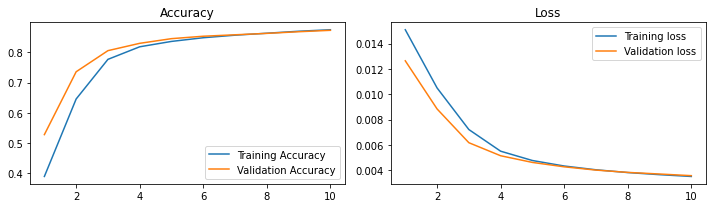


Training with Neurons = 10, Learning rate = 0.0001, Epochs = 20
  Train accuracy = 31.31%, Train loss = 0.015277             Validation accuracy = 44.38%, Validation loss = 0.012886
  Train accuracy = 58.26%, Train loss = 0.010655             Validation accuracy = 75.37%, Validation loss = 0.008030
  Train accuracy = 79.30%, Train loss = 0.006378             Validation accuracy = 82.31%, Validation loss = 0.005452
  Train accuracy = 83.74%, Train loss = 0.004856             Validation accuracy = 84.80%, Validation loss = 0.004495
  Train accuracy = 85.75%, Train loss = 0.004141             Validation accuracy = 86.50%, Validation loss = 0.003961
  Train accuracy = 87.02%, Train loss = 0.003707             Validation accuracy = 87.44%, Validation loss = 0.003601
  Train accuracy = 87.92%, Train loss = 0.003413             Validation accuracy = 88.17%, Validation loss = 0.003386
  Train accuracy = 88.52%, Train loss = 0.003199             Validation accuracy = 88.60%, Validation loss = 

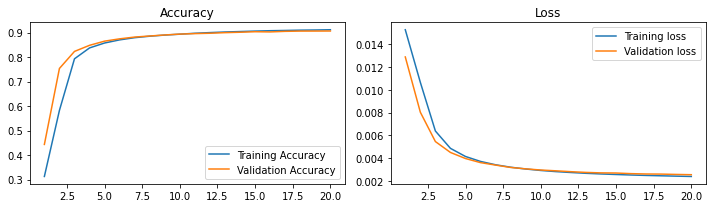


Training with Neurons = 10, Learning rate = 0.001, Epochs = 10
  Train accuracy = 65.51%, Train loss = 0.008411             Validation accuracy = 78.49%, Validation loss = 0.005603
  Train accuracy = 81.66%, Train loss = 0.004760             Validation accuracy = 82.96%, Validation loss = 0.004536
  Train accuracy = 84.35%, Train loss = 0.004174             Validation accuracy = 84.42%, Validation loss = 0.004227
  Train accuracy = 85.74%, Train loss = 0.003884             Validation accuracy = 85.98%, Validation loss = 0.003986
  Train accuracy = 86.67%, Train loss = 0.003666             Validation accuracy = 86.71%, Validation loss = 0.003806
  Train accuracy = 87.37%, Train loss = 0.003499             Validation accuracy = 87.49%, Validation loss = 0.003727
  Train accuracy = 87.94%, Train loss = 0.003371             Validation accuracy = 87.51%, Validation loss = 0.003616
  Train accuracy = 88.23%, Train loss = 0.003280             Validation accuracy = 88.20%, Validation loss = 0

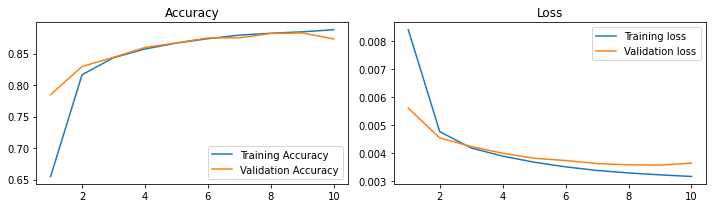


Training with Neurons = 10, Learning rate = 0.001, Epochs = 20
  Train accuracy = 75.49%, Train loss = 0.006394             Validation accuracy = 85.08%, Validation loss = 0.003933
  Train accuracy = 87.08%, Train loss = 0.003404             Validation accuracy = 87.71%, Validation loss = 0.003343
  Train accuracy = 88.68%, Train loss = 0.003009             Validation accuracy = 89.01%, Validation loss = 0.003077
  Train accuracy = 89.48%, Train loss = 0.002806             Validation accuracy = 89.53%, Validation loss = 0.002923
  Train accuracy = 90.10%, Train loss = 0.002676             Validation accuracy = 89.61%, Validation loss = 0.002987
  Train accuracy = 90.32%, Train loss = 0.002620             Validation accuracy = 90.18%, Validation loss = 0.002832
  Train accuracy = 90.68%, Train loss = 0.002539             Validation accuracy = 90.20%, Validation loss = 0.002831
  Train accuracy = 90.89%, Train loss = 0.002489             Validation accuracy = 90.52%, Validation loss = 0

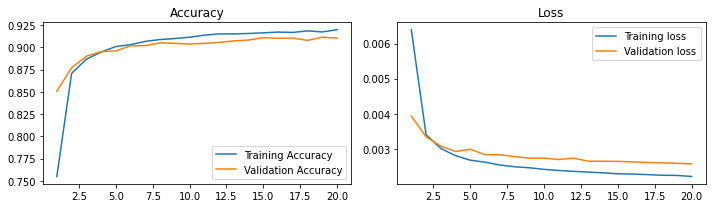


Training with Neurons = 10, Learning rate = 0.01, Epochs = 10
  Train accuracy = 25.02%, Train loss = 0.014438             Validation accuracy = 28.37%, Validation loss = 0.013811
  Train accuracy = 32.83%, Train loss = 0.013035             Validation accuracy = 35.88%, Validation loss = 0.012977
  Train accuracy = 35.65%, Train loss = 0.012566             Validation accuracy = 33.50%, Validation loss = 0.013017
  Train accuracy = 36.20%, Train loss = 0.012384             Validation accuracy = 36.83%, Validation loss = 0.012718
  Train accuracy = 36.49%, Train loss = 0.012315             Validation accuracy = 36.11%, Validation loss = 0.012764
  Train accuracy = 36.48%, Train loss = 0.012280             Validation accuracy = 36.09%, Validation loss = 0.012594
  Train accuracy = 37.01%, Train loss = 0.012213             Validation accuracy = 36.30%, Validation loss = 0.012636
  Train accuracy = 37.45%, Train loss = 0.012176             Validation accuracy = 36.36%, Validation loss = 0.

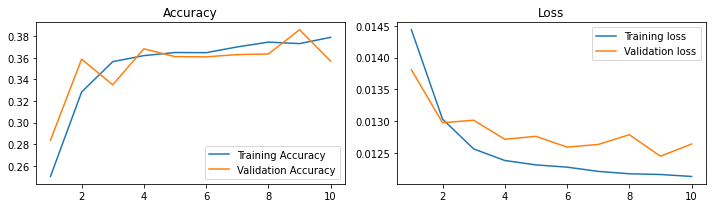


Training with Neurons = 10, Learning rate = 0.01, Epochs = 20
  Train accuracy = 45.55%, Train loss = 0.011214             Validation accuracy = 52.72%, Validation loss = 0.009920
  Train accuracy = 56.13%, Train loss = 0.009326             Validation accuracy = 59.44%, Validation loss = 0.009104
  Train accuracy = 60.87%, Train loss = 0.008945             Validation accuracy = 59.21%, Validation loss = 0.009393
  Train accuracy = 63.10%, Train loss = 0.008635             Validation accuracy = 62.43%, Validation loss = 0.008877
  Train accuracy = 63.95%, Train loss = 0.008493             Validation accuracy = 64.92%, Validation loss = 0.008566
  Train accuracy = 64.10%, Train loss = 0.008475             Validation accuracy = 64.59%, Validation loss = 0.008498
  Train accuracy = 65.27%, Train loss = 0.008331             Validation accuracy = 63.67%, Validation loss = 0.008486
  Train accuracy = 65.52%, Train loss = 0.008275             Validation accuracy = 65.80%, Validation loss = 0.

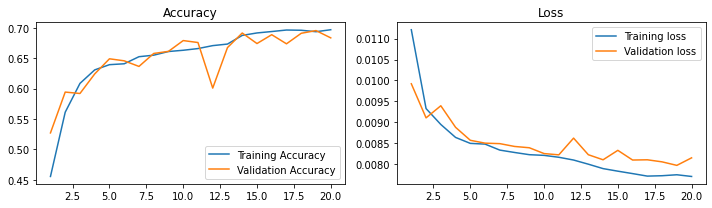


Training with Neurons = 50, Learning rate = 0.0001, Epochs = 10
  Train accuracy = 71.73%, Train loss = 0.009747             Validation accuracy = 84.93%, Validation loss = 0.005470
  Train accuracy = 86.94%, Train loss = 0.004280             Validation accuracy = 88.11%, Validation loss = 0.003683
  Train accuracy = 88.94%, Train loss = 0.003270             Validation accuracy = 89.20%, Validation loss = 0.003124
  Train accuracy = 89.83%, Train loss = 0.002870             Validation accuracy = 89.90%, Validation loss = 0.002857
  Train accuracy = 90.46%, Train loss = 0.002643             Validation accuracy = 90.58%, Validation loss = 0.002684
  Train accuracy = 90.91%, Train loss = 0.002494             Validation accuracy = 91.01%, Validation loss = 0.002563
  Train accuracy = 91.31%, Train loss = 0.002377             Validation accuracy = 91.32%, Validation loss = 0.002466
  Train accuracy = 91.57%, Train loss = 0.002291             Validation accuracy = 91.50%, Validation loss = 

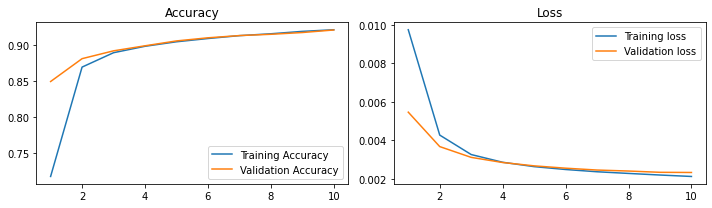


Training with Neurons = 50, Learning rate = 0.0001, Epochs = 20
  Train accuracy = 72.14%, Train loss = 0.010088             Validation accuracy = 83.19%, Validation loss = 0.005841
  Train accuracy = 86.05%, Train loss = 0.004563             Validation accuracy = 87.26%, Validation loss = 0.003853
  Train accuracy = 88.44%, Train loss = 0.003408             Validation accuracy = 89.03%, Validation loss = 0.003220
  Train accuracy = 89.64%, Train loss = 0.002939             Validation accuracy = 89.92%, Validation loss = 0.002889
  Train accuracy = 90.40%, Train loss = 0.002677             Validation accuracy = 90.68%, Validation loss = 0.002680
  Train accuracy = 90.91%, Train loss = 0.002500             Validation accuracy = 91.01%, Validation loss = 0.002554
  Train accuracy = 91.38%, Train loss = 0.002361             Validation accuracy = 91.37%, Validation loss = 0.002445
  Train accuracy = 91.83%, Train loss = 0.002249             Validation accuracy = 91.81%, Validation loss = 

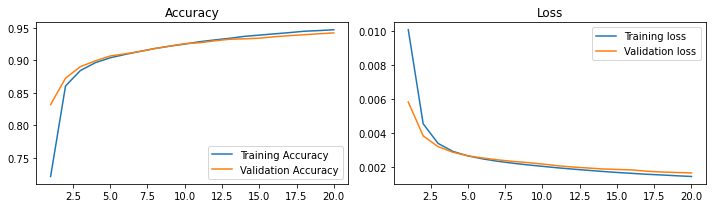


Training with Neurons = 50, Learning rate = 0.001, Epochs = 10
  Train accuracy = 85.59%, Train loss = 0.004193             Validation accuracy = 90.23%, Validation loss = 0.002661
  Train accuracy = 91.14%, Train loss = 0.002370             Validation accuracy = 91.97%, Validation loss = 0.002254
  Train accuracy = 92.49%, Train loss = 0.001995             Validation accuracy = 92.69%, Validation loss = 0.001994
  Train accuracy = 93.76%, Train loss = 0.001674             Validation accuracy = 93.94%, Validation loss = 0.001729
  Train accuracy = 94.71%, Train loss = 0.001444             Validation accuracy = 94.37%, Validation loss = 0.001615
  Train accuracy = 95.31%, Train loss = 0.001268             Validation accuracy = 94.72%, Validation loss = 0.001386
  Train accuracy = 95.68%, Train loss = 0.001155             Validation accuracy = 94.84%, Validation loss = 0.001322
  Train accuracy = 96.07%, Train loss = 0.001046             Validation accuracy = 95.20%, Validation loss = 0

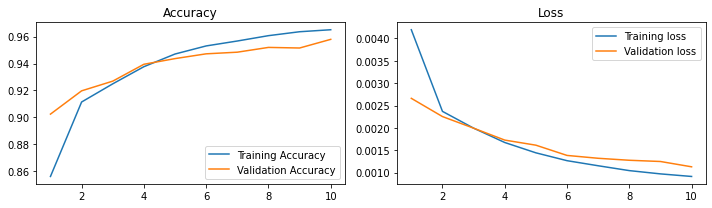


Training with Neurons = 50, Learning rate = 0.001, Epochs = 20
  Train accuracy = 85.42%, Train loss = 0.004234             Validation accuracy = 90.31%, Validation loss = 0.002798
  Train accuracy = 90.94%, Train loss = 0.002406             Validation accuracy = 91.37%, Validation loss = 0.002489
  Train accuracy = 92.33%, Train loss = 0.002078             Validation accuracy = 91.88%, Validation loss = 0.002213
  Train accuracy = 93.07%, Train loss = 0.001847             Validation accuracy = 93.32%, Validation loss = 0.001878
  Train accuracy = 93.95%, Train loss = 0.001632             Validation accuracy = 93.23%, Validation loss = 0.001800
  Train accuracy = 94.49%, Train loss = 0.001472             Validation accuracy = 94.14%, Validation loss = 0.001551
  Train accuracy = 94.95%, Train loss = 0.001348             Validation accuracy = 94.17%, Validation loss = 0.001530
  Train accuracy = 95.44%, Train loss = 0.001226             Validation accuracy = 94.72%, Validation loss = 0

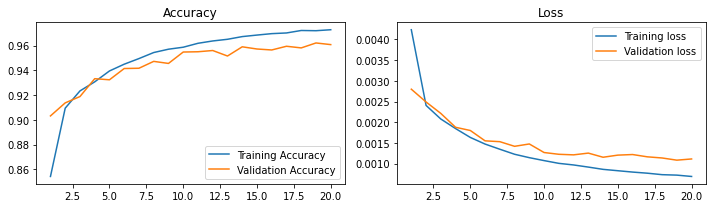


Training with Neurons = 50, Learning rate = 0.01, Epochs = 10
  Train accuracy = 86.46%, Train loss = 0.003557             Validation accuracy = 89.29%, Validation loss = 0.002801
  Train accuracy = 91.19%, Train loss = 0.002282             Validation accuracy = 91.10%, Validation loss = 0.002376
  Train accuracy = 92.30%, Train loss = 0.001997             Validation accuracy = 91.72%, Validation loss = 0.002226
  Train accuracy = 92.62%, Train loss = 0.001890             Validation accuracy = 92.36%, Validation loss = 0.002042
  Train accuracy = 92.92%, Train loss = 0.001841             Validation accuracy = 91.78%, Validation loss = 0.002169
  Train accuracy = 93.22%, Train loss = 0.001795             Validation accuracy = 92.62%, Validation loss = 0.002109
  Train accuracy = 93.38%, Train loss = 0.001719             Validation accuracy = 91.92%, Validation loss = 0.002182
  Train accuracy = 93.58%, Train loss = 0.001674             Validation accuracy = 92.33%, Validation loss = 0.

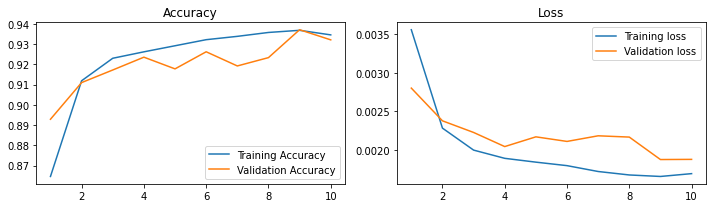


Training with Neurons = 50, Learning rate = 0.01, Epochs = 20
  Train accuracy = 86.82%, Train loss = 0.003356             Validation accuracy = 91.70%, Validation loss = 0.002337
  Train accuracy = 92.10%, Train loss = 0.002057             Validation accuracy = 91.73%, Validation loss = 0.002266
  Train accuracy = 93.14%, Train loss = 0.001833             Validation accuracy = 93.49%, Validation loss = 0.001765
  Train accuracy = 93.53%, Train loss = 0.001702             Validation accuracy = 93.38%, Validation loss = 0.001944
  Train accuracy = 93.49%, Train loss = 0.001704             Validation accuracy = 93.96%, Validation loss = 0.001822
  Train accuracy = 93.83%, Train loss = 0.001636             Validation accuracy = 92.99%, Validation loss = 0.002093
  Train accuracy = 94.05%, Train loss = 0.001566             Validation accuracy = 93.18%, Validation loss = 0.001992
  Train accuracy = 94.14%, Train loss = 0.001570             Validation accuracy = 93.32%, Validation loss = 0.

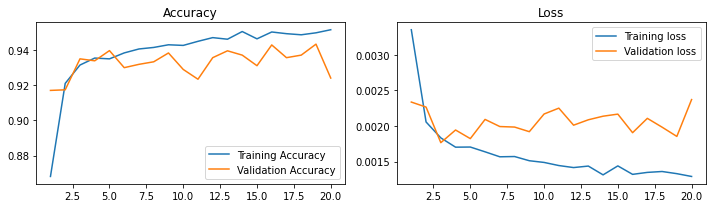


Training with Neurons = 100, Learning rate = 0.0001, Epochs = 10
  Train accuracy = 76.31%, Train loss = 0.008263             Validation accuracy = 86.49%, Validation loss = 0.004456
  Train accuracy = 87.87%, Train loss = 0.003659             Validation accuracy = 88.14%, Validation loss = 0.003303
  Train accuracy = 89.49%, Train loss = 0.002958             Validation accuracy = 89.66%, Validation loss = 0.002912
  Train accuracy = 90.36%, Train loss = 0.002652             Validation accuracy = 90.49%, Validation loss = 0.002681
  Train accuracy = 91.06%, Train loss = 0.002465             Validation accuracy = 90.87%, Validation loss = 0.002536
  Train accuracy = 91.42%, Train loss = 0.002330             Validation accuracy = 91.54%, Validation loss = 0.002428
  Train accuracy = 91.84%, Train loss = 0.002215             Validation accuracy = 91.52%, Validation loss = 0.002368
  Train accuracy = 92.26%, Train loss = 0.002105             Validation accuracy = 92.31%, Validation loss =

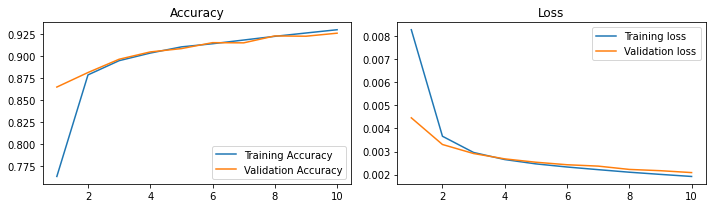


Training with Neurons = 100, Learning rate = 0.0001, Epochs = 20
  Train accuracy = 77.17%, Train loss = 0.008258             Validation accuracy = 86.09%, Validation loss = 0.004425
  Train accuracy = 88.03%, Train loss = 0.003621             Validation accuracy = 89.02%, Validation loss = 0.003233
  Train accuracy = 89.62%, Train loss = 0.002918             Validation accuracy = 89.49%, Validation loss = 0.002892
  Train accuracy = 90.61%, Train loss = 0.002600             Validation accuracy = 90.71%, Validation loss = 0.002609
  Train accuracy = 91.22%, Train loss = 0.002397             Validation accuracy = 91.31%, Validation loss = 0.002434
  Train accuracy = 91.79%, Train loss = 0.002245             Validation accuracy = 91.87%, Validation loss = 0.002319
  Train accuracy = 92.22%, Train loss = 0.002119             Validation accuracy = 92.23%, Validation loss = 0.002222
  Train accuracy = 92.67%, Train loss = 0.002003             Validation accuracy = 92.62%, Validation loss =

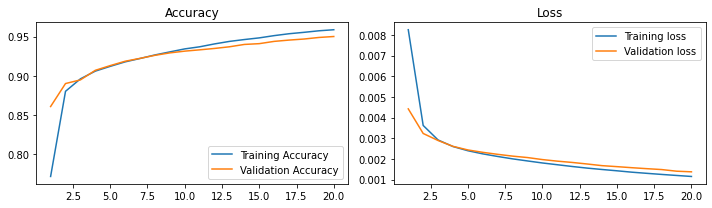


Training with Neurons = 100, Learning rate = 0.001, Epochs = 10
  Train accuracy = 86.49%, Train loss = 0.003756             Validation accuracy = 91.17%, Validation loss = 0.002518
  Train accuracy = 91.88%, Train loss = 0.002130             Validation accuracy = 93.33%, Validation loss = 0.001928
  Train accuracy = 94.01%, Train loss = 0.001610             Validation accuracy = 93.83%, Validation loss = 0.001739
  Train accuracy = 95.10%, Train loss = 0.001287             Validation accuracy = 95.20%, Validation loss = 0.001377
  Train accuracy = 95.98%, Train loss = 0.001064             Validation accuracy = 95.60%, Validation loss = 0.001213
  Train accuracy = 96.52%, Train loss = 0.000918             Validation accuracy = 95.67%, Validation loss = 0.001130
  Train accuracy = 96.94%, Train loss = 0.000815             Validation accuracy = 96.11%, Validation loss = 0.001084
  Train accuracy = 97.25%, Train loss = 0.000720             Validation accuracy = 96.16%, Validation loss = 

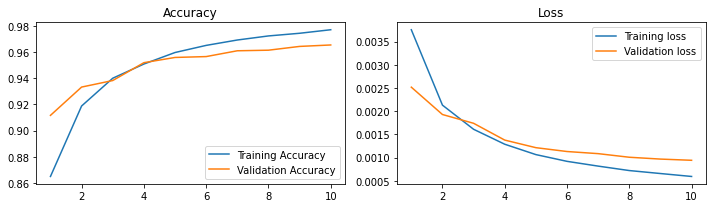


Training with Neurons = 100, Learning rate = 0.001, Epochs = 20
  Train accuracy = 86.72%, Train loss = 0.003668             Validation accuracy = 90.49%, Validation loss = 0.002631
  Train accuracy = 92.40%, Train loss = 0.002054             Validation accuracy = 93.26%, Validation loss = 0.001903
  Train accuracy = 94.08%, Train loss = 0.001569             Validation accuracy = 94.20%, Validation loss = 0.001590
  Train accuracy = 95.22%, Train loss = 0.001267             Validation accuracy = 94.46%, Validation loss = 0.001514
  Train accuracy = 96.10%, Train loss = 0.001047             Validation accuracy = 95.97%, Validation loss = 0.001138
  Train accuracy = 96.60%, Train loss = 0.000887             Validation accuracy = 96.37%, Validation loss = 0.001054
  Train accuracy = 97.02%, Train loss = 0.000786             Validation accuracy = 95.94%, Validation loss = 0.001095
  Train accuracy = 97.20%, Train loss = 0.000710             Validation accuracy = 96.46%, Validation loss = 

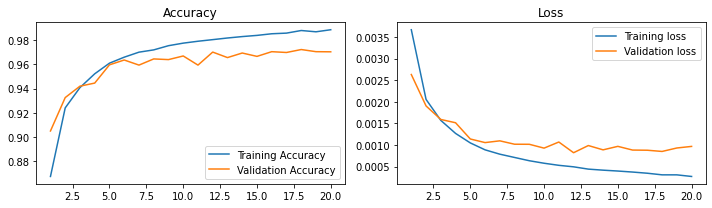


Training with Neurons = 100, Learning rate = 0.01, Epochs = 10
  Train accuracy = 86.54%, Train loss = 0.003570             Validation accuracy = 89.66%, Validation loss = 0.002579
  Train accuracy = 92.60%, Train loss = 0.001963             Validation accuracy = 93.03%, Validation loss = 0.001876
  Train accuracy = 93.42%, Train loss = 0.001739             Validation accuracy = 93.26%, Validation loss = 0.001802
  Train accuracy = 93.60%, Train loss = 0.001683             Validation accuracy = 93.78%, Validation loss = 0.001813
  Train accuracy = 93.97%, Train loss = 0.001584             Validation accuracy = 93.68%, Validation loss = 0.001967
  Train accuracy = 94.06%, Train loss = 0.001584             Validation accuracy = 93.69%, Validation loss = 0.001857
  Train accuracy = 94.03%, Train loss = 0.001571             Validation accuracy = 93.58%, Validation loss = 0.001824
  Train accuracy = 94.29%, Train loss = 0.001494             Validation accuracy = 92.01%, Validation loss = 0

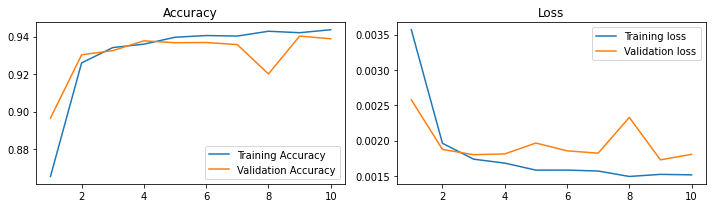


Training with Neurons = 100, Learning rate = 0.01, Epochs = 20
  Train accuracy = 86.86%, Train loss = 0.003449             Validation accuracy = 92.01%, Validation loss = 0.002226
  Train accuracy = 92.69%, Train loss = 0.001893             Validation accuracy = 93.12%, Validation loss = 0.001765
  Train accuracy = 93.08%, Train loss = 0.001777             Validation accuracy = 93.26%, Validation loss = 0.001804
  Train accuracy = 93.89%, Train loss = 0.001602             Validation accuracy = 93.91%, Validation loss = 0.001681
  Train accuracy = 94.03%, Train loss = 0.001584             Validation accuracy = 93.61%, Validation loss = 0.001861
  Train accuracy = 94.46%, Train loss = 0.001473             Validation accuracy = 93.38%, Validation loss = 0.001846
  Train accuracy = 94.58%, Train loss = 0.001438             Validation accuracy = 93.00%, Validation loss = 0.001900
  Train accuracy = 94.43%, Train loss = 0.001454             Validation accuracy = 93.57%, Validation loss = 0

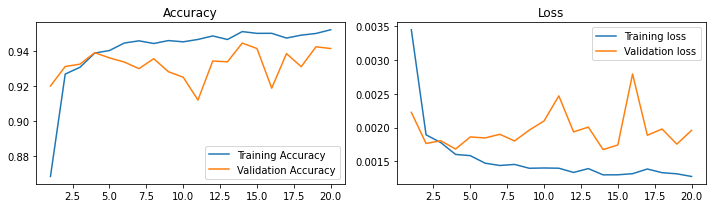

In [36]:
# Optimisable parameters
learning_rate = [0.0001, 0.001, 0.01]
train_epochs = [10, 20]
neurons = [10, 50, 100]

loss_func = nn.CrossEntropyLoss()

optimal_model = None
highest_acc = 0

for neuron in neurons:
  for lr in learning_rate:
    for epoch in train_epochs:
      print('\nTraining with Neurons = {0}, Learning rate = {1}, Epochs = {2}'.format(neuron, lr, epoch))
      model_n = SingleLayerModel(neuron)
      optimiser = optim.Adam(model_n.parameters(), lr=lr)
      results = train_model(model_n, train_data, val_data, epoch)

      plot(*results)

      if(results[0][-1]>highest_acc): # compare current model with best accuracy model return highest accuracy 
        optimal_model = model_n

Run model on test set to get True model accuracy

In [37]:
test, _ = evaluate_model(optimal_model, test_data)
print('Test accuracy = {0:.2%}'.format(test))

Test accuracy = 94.93%


**Best model**
Training with Neurons = 100, Learning rate = 0.001, Epochs = 20

Train accuracy = 98.87%, Validation accuracy = 97.04%
**Test accuracy = 94.93%**

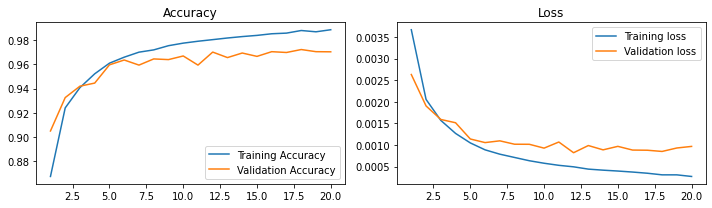
